In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44435")
client

<Client: 'tcp://127.0.0.1:44435' processes=1 threads=1, memory=36.00 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import sys
import gsw
import oceanmodes
import dask.array as dsar
from scipy.io import loadmat
from scipy.interpolate import interp1d
from xgcm.grid import Grid
from numpy.fft import fftfreq, fftshift
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.colors as clr
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/gpfs/research/coaps/tu22/HYCOM50/'

In [4]:
idm = 6709 
jdm = 7373
kdm = 32
layers = np.arange(kdm)

ychunk = 100
xchunk = 80
lchunk = 4

rho0 = 1000. 
g = 9.806 

In [5]:
yS, yN = (30,55)
xW, xE = (-80,-30)
ddeg = 1/50
nC = 200

In [6]:
topo = xr.open_dataset(op.join(ddir,'grid_depth_ATLbc02.nc')
                      ).isel(lat=slice(3030,4894),
                             lon=slice(900,3401))
topo

<xarray.Dataset>
Dimensions:          (lat: 1864, lon: 2501)
Dimensions without coordinates: lat, lon
Data variables:
    latitude         (lat, lon) float32 ...
    longitude        (lat, lon) float32 ...
    NEATL            (lat, lon) float32 ...
    NEATL_HB         (lat, lon) float32 ...
    NEATL_HB_NoNESC  (lat, lon) float32 ...

In [7]:
nF = 25
if nF == 30:
    run = 'ATLb'
    rname = 'NEATL'
else:
    run = 'ATLc'
    rname = 'NEATL_HB' # Just to plot NESC

ds = xr.open_zarr(op.join(ddir,'%4s0.02/topo/Metrics.zarr' % run)
                 ).sel(YC=slice(yS-ddeg,yN+2*ddeg),YG=slice(yS-ddeg,yN+2*ddeg),
                       XC=slice(xW-ddeg,xE+2*ddeg),XG=slice(xW-ddeg,xE+2*ddeg)
                      ).isel(YG=slice(None,-1),XC=slice(1,None)
                            )
ds.coords['layer'] = np.arange(.5,32.5,1)
ds.coords['layerp1'] = np.arange(33)
ds.coords['layerl'] = ds.layerp1[:-1].data
ds.coords['layerp0'] = ds.layerp1[1:-1].data

ds

<xarray.Dataset>
Dimensions:  (YC: 1942, XG: 2473, YG: 1942, XC: 2473, layer: 32, layerp1: 33,
              layerl: 32, layerp0: 31)
Coordinates:
  * XC       (XC) float64 -80.0 -79.98 -79.96 -79.94 ... -30.01 -29.99 -29.96
  * XG       (XG) float64 -80.01 -79.99 -79.97 -79.95 ... -30.02 -30.0 -29.97
  * YC       (YC) float64 29.99 30.01 30.02 30.04 ... 55.01 55.02 55.03 55.04
  * YG       (YG) float64 29.98 30.0 30.01 30.03 ... 55.0 55.01 55.02 55.03
  * layer    (layer) float64 0.5 1.5 2.5 3.5 4.5 ... 27.5 28.5 29.5 30.5 31.5
  * layerp1  (layerp1) int64 0 1 2 3 4 5 6 7 8 9 ... 24 25 26 27 28 29 30 31 32
  * layerl   (layerl) int64 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * layerp0  (layerp0) int64 1 2 3 4 5 6 7 8 9 10 ... 23 24 25 26 27 28 29 30 31
Data variables:
    DXC      (YC, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DXF      (YG, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DXG      (YG, XC) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DYC      (YG, XC) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DYF      (YG, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>
    DYG      (YC, XG) float64 dask.array<chunksize=(71, 27), meta=np.ndarray>

In [8]:
coords={
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "layer",  "outer": "layerp1", 
              "left"  : "layerl", "inner": "layerp0"
             }
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )

grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   layer --> left
  * outer    layerp1 --> center
  * left     layerl --> center
  * inner    layerp0 --> center

Solves the eigenvalue problem
           $$ \frac{\partial q}{\partial t} + \boldsymbol{U} \cdot \nabla q + \boldsymbol{u} \cdot \nabla Q = A_h \nabla^2 q \ \ \ \ \ (1) $$
            
with the boundary conditions of
           $$ \frac{\partial b}{\partial t} + \boldsymbol{U} \cdot \nabla b + \boldsymbol{u} \cdot \nabla (B + N^2 \eta) = 0 \ \ \ \ \ (2) $$
            
at the top and bottom. Each variable is defined as
           $$ q = \nabla^2 \ \psi + \Gamma \ \psi \,, \ \ \ \ Q = \beta y + \Gamma \ \Psi  \ \ \ \ \ (3) $$
where $\Gamma := \frac{\partial}{\partial z} \Big( \frac{f^2}{N^2} \frac{\partial}{\partial z} \Big)$ and
           $$ b = f \frac{\partial \psi}{\partial z} \,, \ \ \ \ B = f \frac{\partial \Psi}{\partial z} \,, \ \ \ \ N^2 = - \frac{g}{\rho_0} \frac{\partial \overline{\rho}}{\partial z} \ \ \ \ \ (4)$$
           $$ \frac{\partial}{\partial z} ( \boldsymbol{f} \times \boldsymbol{u} ) = \nabla b = \frac{g}{\rho_0} \nabla \overline{\rho} \ \ \ \ \ (5) $$
            
Assuming a plane-wave solution, viz.
           $$ \psi = Re \big[ \hat{\psi}(z) e^{i(kx + ly - \omega t)} \big] $$
        
we get
           $$ \nabla^2 \psi = - (k^2 + l^2) \ \psi = -K^2 \psi \,, \ \ \ u = - \frac{\partial \psi}{\partial y} = -il \ \psi \,, \ \ \ v = \frac{\partial \psi}{\partial x} = ik \ \psi\,, \\
            \frac{\partial}{\partial x} q = ik (-K^2 + \Gamma) \ \psi \,, \\ \frac{\partial}{\partial y} q = il (-K^2 + \Gamma) \ \psi
            \frac{\partial}{\partial x} Q = \Gamma V \,, \ \ \ \frac{\partial}{\partial y} Q = \beta - \Gamma U
            \frac{\partial}{\partial x} b = ikf \frac{\partial \psi}{\partial z} \,, \ \ \ \frac{\partial}{\partial y} b = ilf \frac{\partial \psi}{\partial z}
            \frac{\partial}{\partial x} B = f \frac{\partial V}{\partial z} \,, \\ \frac{\partial}{\partial y} B = - f \frac{\partial U}{\partial z} $$
            
so eqn. (1) becomes
           $$ -i \omega (-K^2 + \Gamma) \ \hat{\psi} + ik U (-K^2 + \Gamma) \ \hat{\psi} + il V (-K^2 + \Gamma) \ \hat{\psi} - il \frac{\partial Q}{\partial x} \ \hat{\psi} + ik \frac{\partial Q}{\partial y} \ \hat{\psi} = - A_h K^2 \hat{\psi} $$
           $$ \therefore \ \ (\boldsymbol{K} \cdot \boldsymbol{U} - \omega - i A_h K^2) (\Gamma - K^2) \ \hat{\psi} = - \bigg( k \frac{\partial Q}{\partial y} - l \frac{\partial Q}{\partial x} \bigg) \ \hat{\psi} \ \ \ \ \ (6) $$
        
and eqn. (2) becomes
           $$ -i \omega f \frac{\partial \hat{\psi}}{\partial z} + ikf U \frac{\partial \hat{\psi}}{\partial z} + ilf V \frac{\partial \hat{\psi}}{\partial z} - il \bigg( f \frac{\partial V}{\partial z} + N^2 \frac{\partial \eta}{\partial x} \bigg) \ \hat{\psi} + ik \bigg( -f \frac{\partial U}{\partial z} + N^2 \frac{\partial \eta}{\partial y} \bigg) \ \hat{\psi} = 0 $$
           $$ \therefore \ \ (\boldsymbol{K} \cdot \boldsymbol{U} - \omega) \frac{\partial \hat{\psi}}{\partial z} = \bigg[ k \bigg( \frac{\partial U}{\partial z} - \frac{N^2}{f} \frac{\partial \eta}{\partial y} \bigg) + l \bigg( \frac{\partial V}{\partial z} + \frac{N^2}{f} \frac{\partial \eta}{\partial x} \bigg) \bigg] \ \hat{\psi} \ \ \ \ \ (7) $$
            
Now the eigenfunctions are \hat{\psi} and eigenvalues are \omega so rewriting eqn. (6) and (7) gives
           $$ \bigg[ ( kU + lV - i Ah K^2 ) \bigg( \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 \bigg) + \bigg( k \frac{\partial Q}{\partial y} - l \frac{\partial Q}{\partial x} \bigg) \bigg] \ \hat{\psi} = \omega \bigg( \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 \bigg) \ \hat{\psi} \ \ \ \ \ (8)
            \bigg[ ( kU + lV ) \frac{\partial}{\partial z} - k \bigg( \frac{\partial U}{\partial z} - \frac{N^2}{f} \frac{\partial \eta}{\partial y} \bigg) - l \bigg( \frac{\partial V}{\partial z} + \frac{N^2}{f} \frac{\partial \eta}{\partial x} \bigg) \bigg] \ \hat{\psi} = \omega \frac{\partial}{\partial z} \ \hat{\psi} \ \ \ \ \ (9) $$
            
Hence,
           $$ \boldsymbol{B}^{-1} \boldsymbol{A} \ \hat{\psi} = \omega \ \hat{\psi} \ \ \ \ (-H < z < 0) $$
           $$ \boldsymbol{D}^{-1} \boldsymbol{C} \ \hat{\psi} = \omega \ \hat{\psi} \ \ \ \ \ (z = 0, -H) $$
where
           $$ \boldsymbol{A} = (kU + lV - i A_h K^2) \bigg( \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 \bigg) + \bigg( k \frac{\partial Q}{\partial y} - l \frac{\partial Q}{\partial x} \bigg) $$
           $$ \boldsymbol{B} = \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 $$
           $$ \boldsymbol{C} = (kU + lV) \frac{\partial}{\partial z} - k \bigg( \frac{\partial U}{\partial z} - \frac{N^2}{f} \frac{\partial \eta}{\partial y} \bigg) - l \bigg( \frac{\partial V}{\partial z} + \frac{N^2}{f} \frac{\partial \eta}{\partial x} \bigg) $$
           $$ \boldsymbol{D} = \frac{\partial}{\partial z} $$
            
Discretizing the second derivative term gives
           $$ \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} \ \hat{\psi} = \frac{\partial}{\partial z} \bigg( \frac{f^2}{N^2} \bigg) \frac{\partial \hat{\psi}}{\partial z} + \frac{f^2}{N^2} \frac{\partial^2 \hat{\psi}}{\partial z^2} \\ = \frac{f^2}{\delta_n} \bigg( \frac{1}{N_{n-1}^2} - \frac{1}{N_n^2} \bigg) \frac{1}{2} \bigg( \frac{\partial \hat{\psi}}{\partial z} \bigg|_n + \frac{\partial \hat{\psi}}{\partial z} \bigg|_{n-1} \bigg) + \frac{f^2}{2} \bigg( \frac{1}{N_n^2} + \frac{1}{N_{n-1}^2} \bigg) \frac{1}{\delta_n} \bigg( \frac{\partial \hat{\psi}}{\partial z} \bigg|_{n-1} - \frac{\partial \hat{\psi}}{\partial z} \bigg|_n \bigg) \\ = \frac{f^2}{\delta_n} \bigg( \frac{1}{N_{n-1}^2} - \frac{1}{N_n^2} \bigg) \frac{1}{2} \bigg( \frac{\hat{\psi}_n - \hat{\psi}_{n+1}}{\Delta_n} + \frac{\hat{\psi}_{n-1} - \hat{\psi}_n}{\Delta_{n-1}} \bigg) + \frac{f^2}{2} \bigg( \frac{1}{N_n^2} + \frac{1}{N_{n-1}^2} \bigg) \frac{1}{\delta_n} \bigg( \frac{\hat{\psi}_{n-1} - \hat{\psi}_n}{\Delta_{n-1}} - \frac{\hat{\psi}_n - \hat{\psi}_{n+1}}{\Delta_n} \bigg) \\ = \frac{f^2}{\delta_n} \bigg[ \frac{\hat{\psi}_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) \hat{\psi}_n + \frac{\hat{\psi}_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg] $$
            
so for the interior ocean $(-H < z < 0)$, eqn. (8) becomes
           $$ (kU_n + lV_n - i A_h K^2) \bigg[ \frac{f^2}{\delta_n} \bigg\{ \frac{\hat{\psi}_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) \hat{\psi}_n + \frac{\hat{\psi}_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg\} - K^2 \hat{\psi}_n \bigg] + \bigg( k \frac{\partial Q}{\partial y} \bigg|_n - l \frac{\partial Q}{\partial x} \bigg|_n \bigg) \hat{\psi}_n = \omega \bigg[ \frac{f^2}{\delta_n} \bigg\{ \frac{\hat{\psi}_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) \hat{\psi}_n + \frac{\hat{\psi}_{n-1}}{N^2_{n-1} \Delta_{n-1}} \bigg\} - K^2 \hat{\psi}_n \bigg] $$
            
Thus, for $\hat{\psi}_{n-1}$ :
           $$ (kU_n + lV_n - i A_h K^2) \frac{f^2}{\delta_n} \frac{1}{N_{n-1}^2 \Delta_{n-1}} \hat{\psi}_{n-1} = \omega \frac{f^2}{\delta_n} \frac{1}{N_{n-1}^2 \Delta_{n-1}} \hat{\psi}_{n-1} $$
and $\hat{\psi}_n$ :
           $$ (kU_n + lV_n - i A_h K^2) \bigg\{ - \frac{f^2}{\delta_n} \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) - K^2 \bigg\} + k \frac{\partial Q}{\partial y} \bigg|_n - l \frac{\partial Q}{\partial x} \bigg|_n \bigg] \hat{\psi}_n = \omega \bigg\{ - \frac{f^2}{\delta_n} \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) - K^2 \bigg\} \hat{\psi}_n $$
and $\hat{\psi}_{n+1}$ :
           $$ (kU_n + lV_n - i A_h K^2) \frac{f^2}{\delta_n} \frac{1}{N_n^2 \Delta_n} \hat{\psi}_{n+1} = \omega \frac{f^2}{\delta_n} \frac{1}{N_n^2 \Delta_n} \hat{\psi}_{n+1} $$
            
where
           $$ \frac{\partial Q}{\partial x} \bigg|_n = \frac{f^2}{\delta_n} \bigg\{ \frac{V_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) V_n + \frac{V_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg\} $$
           $$ \frac{\partial Q}{\partial y} \bigg|_n = \beta - \frac{f^2}{\delta_n} \bigg\{ \frac{U_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) U_n + \frac{U_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg\} $$
            
At the boundaries, eqn. (9) becomes
           $$ \bigg( k \frac{U_0 + U_1}{2} + l \frac{V_0 + V_1}{2} \bigg) \frac{\hat{\psi}_0 - \hat{\psi}_1}{\Delta_0} - \bigg\{ k \bigg( \frac{U_0 - U_1}{\Delta_0} - \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial y} \bigg) + l \bigg( \frac{V_0 - V_1}{\Delta_0} + \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial x} \bigg) \bigg\} \frac{\hat{\psi}_1 + \hat{\psi}_0}{2} = \omega \frac{\hat{\psi}_0 - \hat{\psi}_1}{\Delta_0} $$
Therefore at the surface $\psi_0$ :
           $$ \bigg[ \bigg( k \frac{U_0 + U_1}{2} + l \frac{V_0 + V_1}{2} \bigg) \frac{1}{\Delta_0} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_0 - U_1}{\Delta_0} - \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial y} \bigg) + l \bigg( \frac{V_0 - V_1}{\Delta_0} + \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_0 = \omega \frac{1}{\Delta_0} \hat{\psi}_0 $$
            
and $\psi_1$ :
           $$ \bigg[ \bigg( k \frac{U_0 + U_1}{2} + l \frac{V_0 + V_1}{2} \bigg) \frac{-1}{\Delta_0} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_0 - U_1}{\Delta_0} - \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial y} \bigg) + l \bigg( \frac{V_0 - V_1}{\Delta_0} + \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_1 = \omega \frac{-1}{\Delta_0} \hat{\psi}_1 $$
and the same applies for the bottom $\psi_{J-1}$ :
           $$ \bigg[ \bigg( k \frac{U_{J-1} + U_J}{2} + l \frac{V_{J-1} + V_J}{2} \bigg) \frac{1}{\Delta_{J-1}} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_{J-1} - U_J}{\Delta_{J-1}} - \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial y} \bigg) + l \bigg( \frac{V_{J-1} - V_J}{\Delta_{J-1}} + \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_{J-1} = \omega \frac{1}{\Delta_{J-1}} \hat{\psi}_{J-1} $$
and $\psi_J$ :
           $$ \bigg[ \bigg( k \frac{U_{J-1} + U_J}{2} + l \frac{V_{J-1} + V_J}{2} \bigg) \frac{-1}{\Delta_{J-1}} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_{J-1} - U_J}{\Delta_{J-1}} - \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial y} \bigg) + l \bigg( \frac{V_{J-1} - V_J}{\Delta_{J-1}} + \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_J = \omega \frac{-1}{\Delta_{J-1}} \hat{\psi}_J $$
    

In [9]:
import warnings
from scipy.sparse import lil_matrix, csc_matrix, csr_matrix
from scipy.sparse.linalg import eigs, inv
from scipy.linalg import eig

def _maybe_truncate_above_topography(z, *args):
    """
    Return truncated versions of z and arg if arg is masked or nan.
    """
    ndata = len(args)
    
    # checks on shapes of stuff
    for n in range(ndata):
        if not z.shape == args[n].shape:
            raise ValueError('z and f must have the same length')
            
        if ndata > 1 and n < ndata-1:
            if not args[n].shape == args[n+1].shape:
                raise ValueError('All variables should have same length before truncation')
            if not (np.ma.masked_invalid(args[n]).mask.all() 
                    == np.ma.masked_invalid(args[n+1]).mask.all()):
                raise ValueError('All variables must have same mask before truncation')
            if not (np.ma.masked_invalid(args[n]).compressed().shape 
                    == np.ma.masked_invalid(args[n+1]).compressed().shape):
                raise ValueError('All variables must have same length after truncation')

        fm = np.ma.masked_invalid(args[n])
        
        # check to make sure the mask is only at the bottom
        # if not fm.mask[-1]:
        #     raise ValueError('topography should be at the bottom of the column')
        # the above check was redundant with this one
        if fm.mask[-1] and np.diff(fm.mask).sum() != 1:
            raise ValueError('topographic mask should be monotonic')
        
        if ndata > 1:    
            if n == 0:
                fout = np.zeros((ndata, len(fm.compressed())))
            fout[n] = fm.compressed()
        else:
            fout = fm.compressed()
   
    zout = z[~fm.mask]
    
    return zout, fout

def instability_analysis_from_N2_profile(zN2, N2, f0, beta, k, l, zU, ubar, vbar, etax, etay, Ah=0.,
                                         sort='LI', num=4, depth=None, **kwargs):
    """Calculate baroclinic unstable modes from a profile of buoyancy frequency.
        Solves the eigenvalue problem
            \frac{\partial q}{\partial t} + \boldsymbol{U} \cdot \nabla q + \boldsymbol{u} \cdot \nabla Q = Ah \nabla^2 q \ \ \ \ \ (1)
            
        with the boundary conditions of
            \frac{\partial b}{\partial t} + \boldsymbol{U} \cdot \nabla b + \boldsymbol{u} \cdot \nabla (B + N^2 \eta) = 0 \ \ \ \ \ (2)
            
        at the top and bottom. Each variable is defined as
            q = \nabla^2 \ \psi + \Gamma \ \psi \ , \ \ \ \ Q = \beta y + \Gamma \ \Psi  \ \ \ \ \ (3)
        where $\Gamma := \frac{\partial}{\partial z} \Big( \frac{f^2}{N^2} \frac{\partial}{\partial z} \Big)$ and
            b = f \frac{\partial \psi}{\partial z} \ , \ \ \ \ B = f \frac{\partial \Psi}{\partial z} \ , \ \ \ \ N^2 = - \frac{g}{\rho_0} \frac{\partial \overline{\rho}}{\partial z} \ \ \ \ \ (4)
            \frac{\partial}{\partial z} ( \boldsymbol{f} \times \boldsymbol{u} ) = \nabla b = \frac{g}{\rho_0} \nabla \overline{\rho} \ \ \ \ \ (5)
            
        Assuming a plane-wave solution, viz.
            \psi = Re \big[ \hat{\psi}(z) e^{i(kx + ly - \omega t)} \big]
        
        we get
            \nabla^2 \psi = - (k^2 + l^2) \ \psi = -K^2 \psi \ , \ \ \ u = - \frac{\partial \psi}{\partial y} = -il \ \psi \ , \ \ \ v = \frac{\partial \psi}{\partial x} = ik \ \psi
            \frac{\partial}{\partial x} q = ik (-K^2 + \Gamma) \ \psi \ , \ \ \ \frac{\partial}{\partial y} q = il (-K^2 + \Gamma) \ \psi
            \frac{\partial}{\partial x} Q = \Gamma V \ , \ \ \ \frac{\partial}{\partial y} Q = \beta - \Gamma U
            \frac{\partial}{\partial x} b = ikf \frac{\partial \psi}{\partial z} \ , \ \ \ \frac{\partial}{\partial y} b = ilf \frac{\partial \psi}{\partial z}
            \frac{\partial}{\partial x} B = f \frac{\partial V}{\partial z} \ , \ \ \ \frac{\partial}{\partial y} B = - f \frac{\partial U}{\partial z}
            
        so eqn. (1) becomes
            -i \omega (-K^2 + \Gamma) \ \hat{\psi} + ik U (-K^2 + \Gamma) \ \hat{\psi} + il V (-K^2 + \Gamma) \ \hat{\psi} - il \frac{\partial Q}{\partial x} \ \hat{\psi} + ik \frac{\partial Q}{\partial y} \ \hat{\psi} = - Ah K^2 \hat{\psi}
            \therefore \ \ (\boldsymbol{K} \cdot \boldsymbol{U} - \omega - i Ah K^2) (\Gamma - K^2) \ \hat{\psi} = - \bigg( k \frac{\partial Q}{\partial y} - l \frac{\partial Q}{\partial x} \bigg) \ \hat{\psi} \ \ \ \ \ (6)
        
        and eqn. (2) becomes
            -i \omega f \frac{\partial \hat{\psi}}{\partial z} + ikf U \frac{\partial \hat{\psi}}{\partial z} + ilf V \frac{\partial \hat{\psi}}{\partial z} - il \bigg( f \frac{\partial V}{\partial z} + N^2 \frac{\partial \eta}{\partial x} \bigg) \ \hat{\psi} + ik \bigg( -f \frac{\partial U}{\partial z} + N^2 \frac{\partial \eta}{\partial y} \bigg) \ \hat{\psi} = 0
            \therefore \ \ (\boldsymbol{K} \cdot \boldsymbol{U} - \omega) \frac{\partial \hat{\psi}}{\partial z} = \bigg[ k \bigg( \frac{\partial U}{\partial z} - \frac{N^2}{f} \frac{\partial \eta}{\partial y} \bigg) + l \bigg( \frac{\partial V}{\partial z} + \frac{N^2}{f} \frac{\partial \eta}{\partial x} \bigg) \bigg] \ \hat{\psi} \ \ \ \ \ (7)
            
        Now the eigenfunctions are \hat{\psi} and eigenvalues are \omega so rewriting eqn. (6) and (7) gives
            \bigg[ ( kU + lV - i Ah K^2 ) \bigg( \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 \bigg) + \bigg( k \frac{\partial Q}{\partial y} - l \frac{\partial Q}{\partial x} \bigg) \bigg] \ \hat{\psi} = \omega \bigg( \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 \bigg) \ \hat{\psi} \ \ \ \ \ (8)
            \bigg[ ( kU + lV ) \frac{\partial}{\partial z} - k \bigg( \frac{\partial U}{\partial z} - \frac{N^2}{f} \frac{\partial \eta}{\partial y} \bigg) - l \bigg( \frac{\partial V}{\partial z} + \frac{N^2}{f} \frac{\partial \eta}{\partial x} \bigg) \bigg] \ \hat{\psi} = \omega \frac{\partial}{\partial z} \ \hat{\psi} \ \ \ \ \ (9)
            
        Hence,
            \boldsymbol{B}^{-1} \boldsymbol{A} \ \hat{\psi} = \omega \ \hat{\psi} \ \ \ \ (-H < z < 0)
            \boldsymbol{D}^{-1} \boldsymbol{C} \ \hat{\psi} = \omega \ \hat{\psi} \ \ \ \ \ (z = 0, -H)
        where
            \boldsymbol{A} = (kU + lV - i Ah K^2) \bigg( \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2 \bigg) + \bigg( k \frac{\partial Q}{\partial y} - l \frac{\partial Q}{\partial x} \bigg)
            \boldsymbol{B} = \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} - K^2
            \boldsymbol{C} = (kU + lV) \frac{\partial}{\partial z} - k \bigg( \frac{\partial U}{\partial z} - \frac{N^2}{f} \frac{\partial \eta}{\partial y} \bigg) - l \bigg( \frac{\partial V}{\partial z} + \frac{N^2}{f} \frac{\partial \eta}{\partial x} \bigg)
            \boldsymbol{D} = \frac{\partial}{\partial z}
            
        Discretizing the second derivative term gives
            \frac{\partial}{\partial z} \frac{f^2}{N^2} \frac{\partial}{\partial z} \ \hat{\psi} = \frac{\partial}{\partial z} \bigg( \frac{f^2}{N^2} \bigg) \frac{\partial \hat{\psi}}{\partial z} + \frac{f^2}{N^2} \frac{\partial^2 \hat{\psi}}{\partial z^2} \\ = \frac{f^2}{\delta_n} \bigg( \frac{1}{N_{n-1}^2} - \frac{1}{N_n^2} \bigg) \frac{1}{2} \bigg( \frac{\partial \hat{\psi}}{\partial z} \bigg|_n + \frac{\partial \hat{\psi}}{\partial z} \bigg|_{n-1} \bigg) + \frac{f^2}{2} \bigg( \frac{1}{N_n^2} + \frac{1}{N_{n-1}^2} \bigg) \frac{1}{\delta_n} \bigg( \frac{\partial \hat{\psi}}{\partial z} \bigg|_{n-1} - \frac{\partial \hat{\psi}}{\partial z} \bigg|_n \bigg) \\ = \frac{f^2}{\delta_n} \bigg( \frac{1}{N_{n-1}^2} - \frac{1}{N_n^2} \bigg) \frac{1}{2} \bigg( \frac{\hat{\psi}_n - \hat{\psi}_{n+1}}{\Delta_n} + \frac{\hat{\psi}_{n-1} - \hat{\psi}_n}{\Delta_{n-1}} \bigg) + \frac{f^2}{2} \bigg( \frac{1}{N_n^2} + \frac{1}{N_{n-1}^2} \bigg) \frac{1}{\delta_n} \bigg( \frac{\hat{\psi}_{n-1} - \hat{\psi}_n}{\Delta_{n-1}} - \frac{\hat{\psi}_n - \hat{\psi}_{n+1}}{\Delta_n} \bigg) \\ = \frac{f^2}{\delta_n} \bigg[ \frac{\hat{\psi}_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) \hat{\psi}_n + \frac{\hat{\psi}_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg]
            
        so for the interior ocean (0 < z < H), eqn. (8) becomes
            (kU_n + lV_n - i Ah K^2) \bigg[ \frac{f^2}{\delta_n} \bigg\{ \frac{\hat{\psi}_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) \hat{\psi}_n + \frac{\hat{\psi}_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg\} - K^2 \hat{\psi}_n \bigg] + \bigg( k \frac{\partial Q}{\partial y} \bigg|_n - l \frac{\partial Q}{\partial x} \bigg|_n \bigg) \hat{\psi}_n = \omega \bigg[ \frac{f^2}{\delta_n} \bigg\{ \frac{\hat{\psi}_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) \hat{\psi}_n + \frac{\hat{\psi}_{n-1}}{N^2_{n-1} \Delta_{n-1}} \bigg\} - K^2 \hat{\psi}_n \bigg]
            
        Thus, for \hat{\psi}_{n-1} :
            (kU_n + lV_n - i Ah K^2) \frac{f^2}{\delta_n} \frac{1}{N_{n-1}^2 \Delta_{n-1}} \hat{\psi}_{n-1} = \omega \frac{f^2}{\delta_n} \frac{1}{N_{n-1}^2 \Delta_{n-1}} \hat{\psi}_{n-1}
        and \hat{\psi}_n :
            (kU_n + lV_n - i Ah K^2) \bigg\{ - \frac{f^2}{\delta_n} \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) - K^2 \bigg\} + k \frac{\partial Q}{\partial y} \bigg|_n - l \frac{\partial Q}{\partial x} \bigg|_n \bigg] \hat{\psi}_n = \omega \bigg\{ - \frac{f^2}{\delta_n} \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) - K^2 \bigg\} \hat{\psi}_n
        and \hat{\psi}_{n+1} :
            (kU_n + lV_n - i Ah K^2) \frac{f^2}{\delta_n} \frac{1}{N_n^2 \Delta_n} \hat{\psi}_{n+1} = \omega \frac{f^2}{\delta_n} \frac{1}{N_n^2 \Delta_n} \hat{\psi}_{n+1}
            
        where
            \frac{\partial Q}{\partial x} \bigg|_n = \frac{f^2}{\delta_n} \bigg\{ \frac{V_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) V_n + \frac{V_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg\}
            \frac{\partial Q}{\partial y} \bigg|_n = \beta - \frac{f^2}{\delta_n} \bigg\{ \frac{U_{n+1}}{N_n^2 \Delta_n} - \bigg( \frac{1}{N_n^2 \Delta_n} + \frac{1}{N_{n-1}^2 \Delta_{n-1}} \bigg) U_n + \frac{U_{n-1}}{N_{n-1}^2 \Delta_{n-1}} \bigg\}
            
        At the boundaries, eqn. (9) becomes
            \bigg( k \frac{U_0 + U_1}{2} + l \frac{V_0 + V_1}{2} \bigg) \frac{\hat{\psi}_0 - \hat{\psi}_1}{\Delta_0} - \bigg\{ k \bigg( \frac{U_0 - U_1}{\Delta_0} - \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial y} \bigg) + l \bigg( \frac{V_0 - V_1}{\Delta_0} + \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial x} \bigg) \bigg\} \frac{\hat{\psi}_1 + \hat{\psi}_0}{2} = \omega \frac{\hat{\psi}_0 - \hat{\psi}_1}{\Delta_0}
        Therefore at the surface \psi_0 :
            \bigg[ \bigg( k \frac{U_0 + U_1}{2} + l \frac{V_0 + V_1}{2} \bigg) \frac{1}{\Delta_0} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_0 - U_1}{\Delta_0} - \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial y} \bigg) + l \bigg( \frac{V_0 - V_1}{\Delta_0} + \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_0 = \omega \frac{1}{\Delta_0} \hat{\psi}_0
            
        and \psi_1 :
            \bigg[ \bigg( k \frac{U_0 + U_1}{2} + l \frac{V_0 + V_1}{2} \bigg) \frac{-1}{\Delta_0} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_0 - U_1}{\Delta_0} - \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial y} \bigg) + l \bigg( \frac{V_0 - V_1}{\Delta_0} + \frac{N_0^2}{f} \frac{\partial \eta_s}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_1 = \omega \frac{-1}{\Delta_0} \hat{\psi}_1
        and the same applies for the bottom \psi_{J-1} :
            \bigg[ \bigg( k \frac{U_{J-1} + U_J}{2} + l \frac{V_{J-1} + V_J}{2} \bigg) \frac{1}{\Delta_{J-1}} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_{J-1} - U_J}{\Delta_{J-1}} - \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial y} \bigg) + l \bigg( \frac{V_{J-1} - V_J}{\Delta_{J-1}} + \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_{J-1} = \omega \frac{1}{\Delta_{J-1}} \hat{\psi}_{J-1}
        and \psi_J :
            \bigg[ \bigg( k \frac{U_{J-1} + U_J}{2} + l \frac{V_{J-1} + V_J}{2} \bigg) \frac{-1}{\Delta_{J-1}} - \frac{1}{2} \bigg\{ k \bigg( \frac{U_{J-1} - U_J}{\Delta_{J-1}} - \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial y} \bigg) + l \bigg( \frac{V_{J-1} - V_J}{\Delta_{J-1}} + \frac{N_{J-1}^2}{f} \frac{\partial \eta_b}{\partial x} \bigg) \bigg\} \bigg] \ \hat{\psi}_J = \omega \frac{-1}{\Delta_{J-1}} \hat{\psi}_J
    
    
        Parameters
        ----------
        zN2 : array_like
            The depths at which N2 is given. Starts shallow, increases
            positive downward.
        N2 : array_like
            The squared buoyancy frequency (units s^-2). Points below topography
            should be masked or nan.
        f0 : float
            Coriolis parameter.
        Q : array_like
            The background QGPV 
            (\beta y + \left ( \nabla^2 + \frac{d}{dz} \frac{f_0^2}{N^2} \frac{d \Psi}{d z} \right ))
            and Psi is the streamfunction of the background velocity.
        etax, etay : array_like
            The topographic horizontal gradient at the top and bottom.
        B : array_like
            The background buoyancy
        k, l : float
            Parameters to define the horizontal wavenumber
        zU : array_like
            The depths at which ubar/vbar are given. Starts shallow, increases
            positive downward.
        ubar, vbar : array_like
            Time averaged horizontal velocitites [units m/s]. Points below topography
            should be masked or nan.
        Ah : float
            Lateral viscosity
        sort: string, optional
            Sorts the eigenvalues depending on the given argument
        num: integer, optional
            Number of eigenvalues returned
        depth : float, optional
            Total water column depth. If missing will be inferred from z.
        kwargs : optional
            Additional parameters to pass to scipy.sparse.linalg.eigs for
            eigenvalue computation (check documentation:
            http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.sparse.linalg.eigs.html
            for how to define other parameters)
    
    
        Returns
        -------
        zpsi : array_like
            The depths at which phi is defined. Different from z.
        psi : array_like
            eigenvectors
        omega: array_like
            eigenvalues (imaginary part is the growth rate)
    """
    nz_orig = len(zN2)
    zc, N2 = _maybe_truncate_above_topography(zN2, N2)
    dzc = np.hstack(np.diff(zc))
    zf, UV = _maybe_truncate_above_topography(zU, ubar, vbar)
    dzf = np.hstack(np.diff(zf))
    ubar = UV[0]
    vbar = UV[1]
    # make sure length of N2 is one shorter than velocities
    if len(N2) > len(ubar)-1:
        raise ValueError('N2 has the same or longer length than horizontal velocities')
    elif len(N2) < len(ubar)-1:
        warnings.warn('N2 is shorter than horizontal velocities by more than one element')
    
    # make sure z is increasing
    if not np.all(dzc > 0):
        raise ValueError('z should be monotonically increasing')
    if not np.all(dzf > 0):
        raise ValueError('z should be monotonically increasing')
    if depth is None:
        depth = zf[-1]
    else:
        if depth < zf[-1]:
            raise ValueError('depth should not be less than maximum z')
    
    return _instability_analysis_from_N2_profile_raw(
                                    zc, N2, f0, beta, k, l, zf, ubar, vbar, etax, etay, Ah,
                                    sort=sort, num=num, depth=depth, **kwargs)

def _instability_analysis_from_N2_profile_raw(zc, N2, f0, beta, k, l, zf, ubar, vbar, etax, etay, Ah,
                                              sort='LI', num=4, depth=None, **kwargs):
    nz = len(zc)

    ### vertical discretization ###

    # ~~~~~ zf[0]==0, phi[0] ~~~~
    #
    # ----- zc[0], N2[0] --------
    #
    # ----- zf[1], phi[1] -------
    # ...
    # ---- zc[nz-1], N2[nz-1] ---
    #
    # ~~~~ zf[nz], phi[nz] ~~~~~~

    # just for notation's sake
    # (user shouldn't worry about discretization)
    dzc = np.hstack(np.diff(zc))
    dzf = np.diff(zf)
    
    ##################
    # We want a matrix representation of the operator such that
    #
    #     np.dot(L, psi) = omega * np.dot(G, psi)
    ##################
    
    omega = np.zeros( (num, len(l), len(k)), dtype=np.complex128 )
    psi = np.zeros( (nz+1, num, len(l), len(k)), dtype=np.complex128 )
    
    for j in range(len(l)):
        for i in range(len(k)):
            
            if Ah == 0.:
                L = lil_matrix((nz+1, nz+1), dtype=np.float64)
            else:
                L = lil_matrix((nz+1, nz+1), dtype=np.complex128)
            G = L.copy()

            ################
            # n = 0 (surface)
            #
            # From the discretized equations above, at the surface we get
            #     L[0, 0] = (( k (U[0] + U[1])/2 + l (V[0] + V[1])/2 ) / dzf[0] 
            #                 - .5*( k ( (U[0] - U[1])/dzf[0] - N2[0]**2/f0 * etay[0] ) + l ( (V[0] - V[1])/dzf[0] + N2[0]**2/f0 * etax[0] ))) 
            #     L[0, 1] = (( k (U[0] + U[1])/2 + l (V[0] + V[1])/2 ) / (-dzf[0]) 
            #                 - .5*( k ( (U[0] - U[1])/dzf[0] - N2[0]/f0 * etay[0] ) + l ( (V[0] - V[1])/dzf[0] + N2[0]/f0 * etax[0] )))
            # and
            #     G[0, 0] = dzf[0]**-1
            #     G[0, 1] = -dzf[0]**-1
            ################
            R = k[i] * .5*(ubar[0]+ubar[1]) + l[j] * .5*(vbar[0]+vbar[1]) 
            D = dzf[0]**-1
            S = .5 * ( k[i] * ( (ubar[0]-ubar[1])*D - N2[0]/f0 * etay[0] )
                       + l[j] * ( (vbar[0]-vbar[1])*D + N2[0]/f0 * etax[0] ) 
                     )

            # print(R,D,S)
            L[0, 0] = R * D - S
            L[0, 1] = R * (-D) - S
            G[0, 0] = D
            G[0, 1] = - D
            # L[0, 0] = R - S * D**-1
            # L[0, 1] = R * (-1.) - S * D**-1
            # G[0, 0] = 1.
            # G[0, 1] = - 1.

            ################
            # n = nz (bottom)
            #
            # From symmetry, at the bottom
            #     L[nz, nz-1] = (( k (U[nz-1] + U[nz])/2 + l (V[nz-1] + V[nz])/2 ) / dzf[nz-1] 
            #           - .5*( k ( (U[nz-1] - U[nz])/dzf[nz-1] - N2[nz-1]**2/f0 * etay[1] ) + l ( (V[nz-1] - V[nz])/dzf[nz-1] + N2[nz-1]**2/f0 * etax[1] ))) 
            #     L[nz, nz] = (( k (U[nz-1] + U[nz])/2 + l (V[nz-1] + V[nz])/2 ) / (-dzf[nz-1]) 
            #           - .5*( k ( (U[nz-1] - U[nz])/dzf[nz-1] - N2[nz-1]/f0 * etay[1] ) + l ( (V[nz-1] - V[nz])/dzf[nz-1] + N2[nz-1]/f0 * etax[1] )))
            # and
            #     G[nz, nz-1] = dzf[nz-1]**-1
            #     G[nz, nz] = -dzf[nz-1]**-1
            ################
            R = k[i] * .5*(ubar[nz-1]+ubar[nz]) + l[j] * .5*(vbar[nz-1]+vbar[nz]) 
            D = dzf[nz-1]**-1
            S = .5 * ( k[i] * ( (ubar[nz-1]-ubar[nz])*D - N2[nz-1]/f0 * etay[1] )
                       + l[j] * ( (vbar[nz-1]-vbar[nz])*D + N2[nz-1]/f0 * etax[1] ) 
                     )

            L[nz, nz-1] = R * D - S
            L[nz, nz] = R * (-D) - S
            G[nz, nz-1] = D
            G[nz, nz] = - D
            # L[nz, nz-1] = R - S * D**-1
            # L[nz, nz] = R * (-1.) - S * D**-1
            # G[nz, nz-1] = 1.
            # G[nz, nz] = - 1.

            ################
            # 0 < n < nz (interior)
            #
            # In the interior, we have
            #     L[n, n-1] = (k U[n] + l V[n] - i Ah K**2) * f**2/dzc[n] / (N2[n-1] * dzf[n-1])
            #     L[n, n] = (k U[n] + l V[n] - i Ah K**2) 
            #                     * ( - f**2/dzc[n] * ( 1/(N2[n] * dzf[n]) + 1/(N2[n-1]*dzf[n-1]) ) - K**2 ) + k*Qy[n] - l*Qx[n] )
            #     L[n, n+1] = (k U[n] + l V[n] - i Ah K**2) * f**2/dzc[n] / (N2[n] * dzf[n])
            # and
            #     G[n, n-1] = f**2/dzc[n] / N2[n-1] / dzf[n-1]
            #     G[n, n] = ( - f**2/dzc[n] * ( 1/(N2[n]*dzf[n]) + 1/(N2[n-1]*dzf[n-1]) ) - K**2 )
            #     G[n, n+1] = f**2/dzc[n] / N2[n] / dzf[n]
            ################
            for n in range(1,nz):
                
                K2 = k[i]**2 + l[j]**2
                if Ah == 0.:
                    R = k[i] * ubar[n] + l[j] * vbar[n]
                else:
                    R = k[i] * ubar[n] + l[j] * vbar[n] - 1j * Ah * K2
                bf = f0**2 * dzc[n-1]**-1
                b_1 = N2[n-1] * dzf[n-1]
                b = N2[n] * dzf[n]
                B_1 = bf * b_1**-1 
                B = - (bf * (b**-1 + b_1**-1) + K2)
                Bt1 = bf * b**-1 

                N2Z = (N2[n]*dzf[n])**-1
                N2Z_1 = (N2[n-1]*dzf[n-1])**-1
                P = ( k[i] * ( beta - bf * ( ubar[n+1] * N2Z
                                             - (N2Z + N2Z_1) * ubar[n]
                                             + N2Z_1 * ubar[n-1] ) )
                      - l[j] * bf * ( vbar[n+1] * N2Z 
                                      - (N2Z + N2Z_1) * vbar[n]
                                      + N2Z_1 * vbar[n-1] )
                    )

                L[n, n-1] = R * B_1
                L[n, n] = R * B + P
                L[n, n+1] = R * Bt1
                G[n, n-1] = B_1
                G[n, n] = B
                G[n, n+1] = Bt1
        #             L[n, n-1] = R
        #             L[n, n] = R + P * B**-1
        #             L[n, n+1] = R
        #             G[n, n-1] = 1.
        #             G[n, n] = 1.
        #             G[n, n+1] = 1.        
                    
            # Return Nans if matrix G is singular
            try:
                # read in kwargs if any
                if len(kwargs) > 0:
                    val, func = eigs( csc_matrix(inv(csc_matrix(G)).dot(csc_matrix(L))), 
                                      k=num, which='LI', v0=kwargs['init_vector'], 
                                      ncv=kwargs['num_Lanczos'], maxiter=kwargs['iteration'],
                                      tol=kwargs['tolerance']
                                    )  # default returns 6 eigenvectors
                else:
                    # try:
                        # num_Lanczos = nz
                    iteration = 10*nz
                    val, func = eigs( csc_matrix(inv(csc_matrix(G)).dot(csc_matrix(L))), 
                                      k=num, which='LI', ncv=None, maxiter=iteration,
                                    )  # default returns 6 eigenvectors
                    # except:
                    #     val, func = eig( csc_matrix(inv(csc_matrix(G)).dot(csc_matrix(L))
                    #                                ).to_array()
                    #                    )
                    #     val = val[:k]
                    #     func = func[:,:k]
                # val, func = eigs( csc_matrix(L), M=csc_matrix(G), Minv=csc_matrix(inv(csc_matrix(G))), 
                #                 k=num, which='LI', ncv=num_Lanczos, maxiter=iteration, **kwargs )

                ###########
                # eigs returns complex values. For a linear-stability analysis, 
                # we don't want the eigenvalues to be real
                ###########
                omega[:, j, i] = val
                psi[:, :, j, i] = func  # Each column is the eigenfunction
            
            except RuntimeError:
                warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)
                omega[:, j, i] = np.nan
                psi[:, :, j, i] = np.nan
    
    ###########
    # they are often sorted and normalized but not always,
    # so we have to do that here.
    # sort them by the imaginary part of the eigenvalues 
    # (growth rate)
    ###########
    omega1d = omega.reshape( (num, len(k)*len(l)) ).imag.max(axis=1)
    p = np.argsort(omega1d)[::-1]
    omega = omega[p]
    psi = psi[:, p]
    
    # return the first 'num' leading modes
    return zf, omega[:num], psi[:, :num]

In [10]:
dsCC = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/Coarse/nC%03d.zarr' 
                           % (run,nF,nC))
                   )
coords={
        # "T": {"center": "time"},
        "X": {"center": "XC", "left" : "XG"},
        "Y": {"center": "YC", "left" : "YG"},
        "Z": {"center": "Z" , "inner": "Zn"}
       }
gridCC = Grid(dsCC, periodic=[],
              coords=coords
             )
f = xr.apply_ufunc(gsw.f, dsCC.TLAT, dask='parallelized').compute()
beta = (gridCC.diff(xr.apply_ufunc(gsw.f, dsCC.VLAT, dask='parallelized'),
                    'Y',boundary='extend'
                   ) 
        / gridCC.interp(dsCC.DYG,'X',boundary='extend')).compute()

In [11]:
nskp = 1
neig = 3
omega = xr.DataArray(np.ones((neig,len(dsCC.YC),len(dsCC.XC))),
                     dims=['mode','YC','XC'],
                     coords={'YC':dsCC.YC,'XC':dsCC.XC}
                    ) * np.nan
nk = 100
k = 2*np.pi*np.linspace(-10e3**-1,10e3**-1,nk) 

for j in range(len(omega.YC)):
    for i in range(len(omega.XC)):
        if dsCC.Depth.isel(YC=j*nskp, XC=i*nskp) > 500.:
            N2 = dsCC.N2.where(dsCC.N2>0.).isel(YC=j*nskp, XC=i*nskp
                                               ).chunk({'Zn':-1}
                                                      ).interpolate_na('Zn', 
                                                            fill_value='extrapolate'
                                                                )
            N2 = N2.where(N2>0.)
            N2 = np.ma.masked_invalid(N2.fillna(N2.min(skipna=True)
                                               ).where(dsCC.Zn
                                                       < dsCC.Depth.isel(YC=j*nskp, XC=i*nskp)
                                                      )
                                     )
            U  = np.ma.masked_invalid(dsCC.U.isel(YC=j*nskp, XC=i*nskp
                                         ).chunk({'Z':-1}).interpolate_na('Z', 
                                                                fill_value='extrapolate'
                                                                ).where(dsCC.Z
                                                                < dsCC.Depth.isel(
                                                                    YC=j*nskp, XC=i*nskp)
                                                                       )
                                     )
            V  = np.ma.masked_invalid(dsCC.V.isel(YC=j*nskp, XC=i*nskp
                                         ).chunk({'Z':-1}).interpolate_na('Z', 
                                                                fill_value='extrapolate'
                                                                ).where(dsCC.Z
                                                                < dsCC.Depth.isel(
                                                                    YC=j*nskp, XC=i*nskp)
                                                                       )
                                     ).compressed()
            Zn = np.ma.masked_array(dsCC.Zn,N2.mask).compressed()
            Z  = np.ma.masked_array(dsCC.Z,U.mask).compressed()
            N2 = N2.compressed()
            U  = U.compressed()
            if len(N2) >= len(U):
                if len(N2) > len(U)+1:
                    print('Interpolation funky!!!')
                    N2 = N2[1:-1]
                    Zn = Zn[1:-1]
                else:
                    if Zn[len(N2)-1] > Z[len(U)-1]:
                        N2 = N2[:-1]
                        Zn = Zn[:-1]
                    else:
                        N2 = N2[1:]
                        Zn = Zn[1:]
            elif len(N2) < len(U)-1:
                if Z[1] < Zn[0]:
                    U = U[1:]
                    V = V[1:]
                    Z = Z[1:]
                elif Z[-2] > Zn[-1]:
                    U = U[:-1]
                    V = V[:-1]
                    Z = Z[:-1]
            print(len(Z),len(Zn))
            
            if len(Zn) > 3:
                _, om, _ = instability_analysis_from_N2_profile(
                                    Zn, N2,
                                    f.isel(YC=j*nskp, XC=i*nskp).data, 
                                    beta.isel(YC=j*nskp, XC=i*nskp).data,
                                    k, k[nk//2:],
                                    Z, U, V,
                                    np.array([0.,0.]), np.array([0.,0.]),
                                    depth=dsCC.Depth.isel(YC=j*nskp, XC=i*nskp).data,
                                    num=neig
                    )
                omega[:,j,i] = np.nanmax(om.imag, axis=(-1,-2))

    print(j)
    
omega.to_dataset(name='omega').to_zarr(op.join(ddir, 
                                            '%4s0.02/%03d/0016-0020/BC-growth/nC%03d.zarr'
                                               % (run,nF,nC)), 
                                       mode='w')

37 36
65 64
63 62
56 55
63 62
67 66


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


66 65


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


59 58


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


45 44
38 37
46 45
50 49
0
15 14
55 54
62 61


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


60 59


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


59 58
66 65
61 60
59 58
53 52


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


43 42


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


34 33


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


36 35
1
32 31


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


52 51


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


61 60
63 62


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


65 64
66 65
64 63


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


60 59
54 53


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


44 43


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


24 23
2
8 7
41 40


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


57 56


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


60 59
53 52


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


48 47


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


59 58


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


57 56


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


52 51


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


34 33
3
10 9
27 26
8 7
33 32


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


57 56
53 52


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


48 47


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


40 39


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


4
31 30


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


56 55
53 52


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


46 45
5
27 26


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


43 42


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


53 52
50 49
45 44
6
38 37


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


51 50


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


46 45
44 43
39 38
7
16 15
46 45


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


44 43


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


40 39


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


29 28


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


34 33


/tmp/ipykernel_1721521/1559809991.py:378: RuntimeWarning: The matrix is ill-conditioned or singular
  warnings.warn('The matrix is ill-conditioned or singular', RuntimeWarning)


8


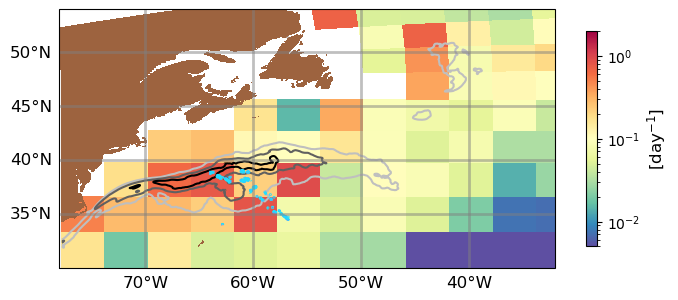

In [12]:
dss = xr.open_zarr(op.join(ddir,'%4s0.02/topo/Coords.zarr' % run)
                  ).isel(YC=slice(3030,4894),XC=slice(900,3401),
                         YG=slice(3030,4894),XG=slice(900,3401))
EKE = xr.DataArray(loadmat(op.join(ddir, '%4s0.02/%4s02_E%03d_GSNAC_0016_0020_myrmn.mat'
                                   % (run,run,nF))
                          )['eke'], dims=['YC','XC'],
                   coords={'YC':dss.YC,'XC':dss.XC}
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),XC=slice(xW-ddeg,xE+2*ddeg)
                       ).isel(XC=slice(1,None))

top = xr.DataArray(topo[rname].where(topo[rname]<3900).where(topo[rname]>1500).data, 
                   dims=['YC','XC'],
                   coords={'YC':dss.YC,'XC':dss.XC}
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),XC=slice(xW-ddeg,xE+2*ddeg)
                       ).isel(XC=slice(1,None))
dsl = xr.open_zarr(op.join(ddir,'%4s0.02/%03d/0016-0020/Rd.zarr' 
                           % (run,nF)))
maskD = np.ma.masked_values(dsl.Depth,0.).mask
dso = xr.open_zarr(op.join(ddir, '%4s0.02/%03d/0016-0020/BC-growth/nC%3d.zarr'
                           % (run,nF,200))
                  )
dsC = xr.open_zarr(op.join(ddir,'%4s0.02/topo/Coords.zarr' % run)
                  ).sel(YC=slice(yS-ddeg,yN+2*ddeg),YG=slice(yS-ddeg,yN+2*ddeg),
                        XC=slice(xW-ddeg,xE+2*ddeg),XG=slice(xW-ddeg,xE+2*ddeg)
                       ).isel(YG=slice(None,-1),XC=slice(1,None)
                             )

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-78, -32, 30, 54], crs=ccrs.PlateCarree())

im = ax.pcolor(dsCC.TLON, dsCC.TLAT, 
               (dso.omega[0]*86400.), 
               cmap='Spectral_r',
               norm=clr.LogNorm(vmax=2., vmin=5e-3),
               rasterized=True
              )

cs1 = ax.contour(dss.tlon.sel(YC=slice(EKE.YC.min(),EKE.YC.max()),
                            XC=slice(EKE.XC.min(),EKE.XC.max()+ddeg)
                           ), 
               dss.tlat.sel(YC=slice(EKE.YC.min(),EKE.YC.max()),
                            XC=slice(EKE.XC.min(),EKE.XC.max()+ddeg)
                           ), 
               EKE.where(EKE>.15), 
               cmap='binary', levels=[.1,.2,.35,.5]
                )
for c in cs1.collections:
    c.set_rasterized(True)

cs2 = ax.contour(dss.tlon.sel(YC=slice(EKE.YC.min(),EKE.YC.max()),
                            XC=slice(EKE.XC.min(),EKE.XC.max()+ddeg)
                           ).sel(YC=slice(34,40),XC=slice(-67,-56)), 
               dss.tlat.sel(YC=slice(EKE.YC.min(),EKE.YC.max()),
                            XC=slice(EKE.XC.min(),EKE.XC.max()+ddeg)
                           ).sel(YC=slice(34,40),XC=slice(-67,-56)), 
               top.sel(YC=slice(34,40),XC=slice(-67,-56)), 
               cmap='cool_r', levels=[1500,1800,2400,3000,3600,3900]
                )
for c in cs2.collections:
    c.set_rasterized(True)

ax.pcolor(dsC.tlon, dsC.tlat, np.ma.masked_values(maskD, 0.),
          vmin=-1, vmax=3, cmap='copper_r',
          rasterized=True)

# ax.set_xlim([-80,-30])
# ax.set_ylim([30,54])

xticks = np.arange(-80, -20, 10)
yticks = np.arange(30, 54, 5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5)

gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(xticks)
gl.ylocator = mticker.FixedLocator(yticks)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'k'}
gl.ylabel_style = {'size': 12, 'color': 'k'}

cbar = fig.colorbar(im, ax=ax, shrink=.7,
                    ticks=[1e-2,1e-1,1e0]
                   )
cbar.set_label(r"[day$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figure/sigBC_%03d_nC%03d.pdf' % (nF,nC)))
plt.show()